In [53]:
import time

import  torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.utils.data as td

定义变量

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_works = 4
batch_size = 64
input_dim= 100
epochs = 25
print("run on ",device.type)

run on  cuda


In [55]:
from typing import Iterable


# loading data
def loading_minist_data(batch_siz:int, works:int)->(Iterable,Iterable):

    train_set = torchvision.datasets.MNIST(root="./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
    test_set = torchvision.datasets.MNIST(root="./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)
    return td.DataLoader(dataset=train_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True), td.DataLoader(dataset=test_set, batch_size=batch_siz, shuffle=True, num_workers=works,drop_last=True)

train_iter ,test_iter = loading_minist_data(batch_size,4)


In [56]:
print("train_iter len ",len(train_iter))
print("all size ",len(train_iter)*batch_size)

train_iter len  937
all size  59968


In [57]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=2,padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32,64,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64,128,kernel_size=3,stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.Flatten(),
            nn.Linear(128*3*3,1),
            nn.Sigmoid(),
        ).to(device)
        self.cnt=0
        self.running_loss=0
        self.loss_func = nn.BCELoss()
        self.loss_metric=[]
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.001)
        pass
    def forward(self,inputs):
        for op in  self.model:
            # print(inputs.shape)
            inputs = op(inputs)
        return inputs
    def train(self,inputs,targets):
        out = self.forward(inputs)
        loss = self.loss_func(out,targets)
        self.running_loss += loss.detach().item()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        pass
    def evaluate_loss(self):
        ts = self.running_loss/(len(train_iter)*batch_size)
        self.loss_metric.append(ts)

        self.running_loss=0

        pass
class Generator(nn.Module):
    def __init__(self,in_dim:int):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # nn.Linear(in_dim, 200),
            # nn.LeakyReLU(0.02),
            # # nn.LayerNorm(200),
            # nn.LayerNorm(200),
            # nn.Linear(200, 784),
            # nn.ReLU(True),
            # nn.Linear(256,28*28),
            # nn.Tanh()
            nn.Linear(in_dim,256*7*7),
            View( shape=(batch_size,256,7,7)),
            # 256*7*7 -> 128*14*14
            # 7 + (2-1)*6 +
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64,1,kernel_size=4,padding=1,stride=2),
            nn.Tanh()
        ).to(device)
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        # counter and accumulator for progress
        self.loss_metric = []
        self.running_loss =0
    def forward(self,inputs):
        for op in  self.model:
            # print(inputs.shape)
            inputs = op(inputs)
        return  inputs
    def train(self,D:Discriminator,inputs,targets):
        gen_out = self.forward(inputs)
        # print(gen_out.shape)
        d_out = D.forward(gen_out)
        loss  = D.loss_func(d_out,targets)
        self.running_loss += loss.detach().item()
        # print(self.running_loss)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    def evaluate_loss(self):
        print("G running loss ",self.running_loss)
        ts = self.running_loss/(len(train_iter)*batch_size)
        self.loss_metric.append(ts)
        self.running_loss=0
        pass
def generate_random_seed(size):
    random_data = torch.randn(size*batch_size).view(batch_size,size)
    return random_data.to(device)


In [58]:
G = Generator(in_dim=input_dim)
G.forward(generate_random_seed(input_dim))

tensor([[[[-0.8083, -0.9254, -0.8693,  ..., -0.9192, -0.9123, -0.9312],
          [-0.1192, -0.9859,  0.7342,  ..., -0.9711, -0.7799, -0.0288],
          [-0.9259, -0.8975, -0.6515,  ..., -0.9322, -0.4463, -0.9535],
          ...,
          [-0.8697, -0.7823, -0.9150,  ..., -0.5105, -0.3685, -0.6806],
          [-0.8797, -0.6988,  0.1512,  ..., -0.9768,  0.9203, -0.9263],
          [-0.6111, -0.6329, -0.6898,  ..., -0.0615, -0.9294,  0.0532]]],


        [[[-0.4912, -0.9585, -0.9734,  ..., -0.9726, -0.9031, -0.5687],
          [-0.6132, -0.7905, -0.6585,  ..., -0.9930, -0.5618,  0.1576],
          [-0.9745, -0.9002, -0.7374,  ..., -0.9843, -0.7116, -0.9864],
          ...,
          [-0.1215, -0.9686, -0.9740,  ...,  0.1827, -0.2012, -0.2143],
          [-0.9838, -0.9589, -0.3384,  ..., -0.9716,  0.9578, -0.5538],
          [-0.4587, -0.0880, -0.4458,  ...,  0.0152, -0.3067, -0.3181]]],


        [[[-0.3632,  0.1292, -0.9722,  ...,  0.0152, -0.7663, -0.4403],
          [-0.4031, -0.929

In [59]:
D = Discriminator()

for k in  range(3):
    for it,_ in train_iter:
        it = it.to(device)
        y = torch.ones(size=(64,1),dtype=torch.float32)
        y = y.to(device)
        D.train(it,y)
    # print(len(train_iter)*batch_size)
    print(D.running_loss/(len(train_iter)*batch_size))
    D.running_loss =0

1.7112986990155347e-05
3.7827784565592265e-08
1.1790510182794584e-08


generate nums is run on  cuda:0


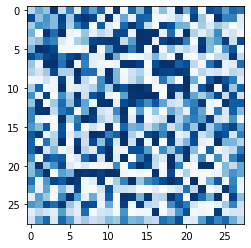

In [60]:
G = Generator(input_dim)

print("generate nums is run on ",generate_random_seed(input_dim).device)

output = G.forward(generate_random_seed(input_dim))
# img = output.detach().numpy().reshape(28,28)
plt.imshow(output.cpu().detach().numpy()[0][0], interpolation='none', cmap='Blues')

In [61]:
%%time
D = Discriminator()
G = Generator(input_dim)
for i in range(epochs):
    print("epoch  {} of {}  ".format(i+1,epochs))
    time_start = time.time()
    for tr_item,_ in train_iter:
        tr_item = tr_item.to(device)
        true_label = torch.ones(size=(batch_size,1),dtype=torch.float32).to(device)
        fake_label = torch.zeros(size=(batch_size,1),dtype=torch.float32).to(device)
        D.train(tr_item,true_label)

        D.train(G.forward(generate_random_seed(input_dim)).detach() , fake_label)
        #
        G.train(D,generate_random_seed(input_dim),true_label)
    D.evaluate_loss()
    G.evaluate_loss()
    print("spend time {}   D loss {} ,G loss {} ".format(time.time()-time_start,D.loss_metric[i],G.loss_metric[i]))

        # break

epoch  1 of 25  
G running loss  8726.190867483616
spend time 41.48455476760864   D loss 7.460138416217439e-05 ,G loss 0.14551412198978816 
epoch  2 of 25  
G running loss  6615.596367239952
spend time 40.777957916259766   D loss 0.0007215254595780207 ,G loss 0.11031877613460432 
epoch  3 of 25  
G running loss  7429.736074209213
spend time 40.77895522117615   D loss 0.0004622701544403661 ,G loss 0.1238950119098388 
epoch  4 of 25  
G running loss  7172.342683014885
spend time 41.33247423171997   D loss 0.0019904897232418317 ,G loss 0.11960283289445846 
epoch  5 of 25  
G running loss  7571.582343220711
spend time 41.84709930419922   D loss 0.00036988236974185473 ,G loss 0.12626037792190353 
epoch  6 of 25  
G running loss  8156.4493370410055
spend time 42.4704315662384   D loss 0.0006377390747303332 ,G loss 0.13601336274414697 
epoch  7 of 25  
G running loss  9330.937313079834
spend time 41.9288809299469   D loss 3.039189877244542e-05 ,G loss 0.15559860780882862 
epoch  8 of 25  
G r

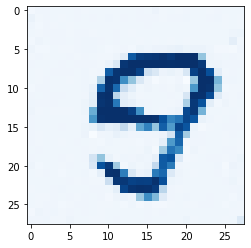

In [62]:
output = G.forward(generate_random_seed(input_dim))
img = output.detach().cpu().numpy().reshape(64,28,28)
plt.imshow(img[9], interpolation='none', cmap='Blues')

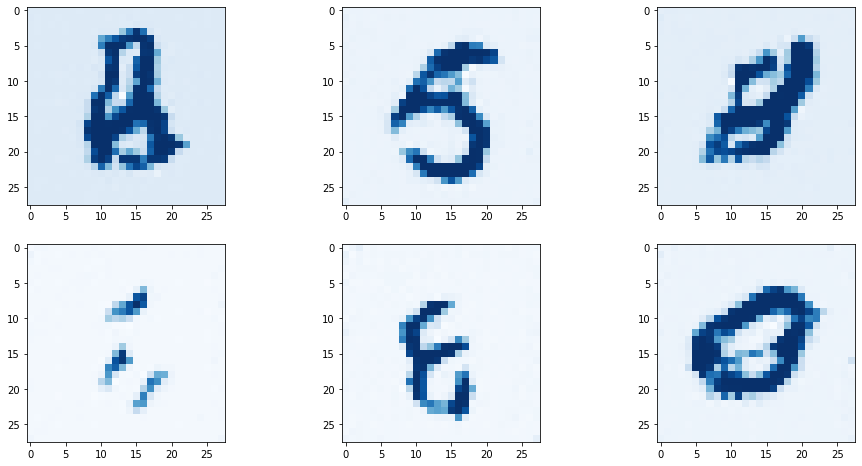

In [63]:
f,axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(input_dim))
        img = output.detach().cpu().numpy()[i*3+j].reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

# for it,_ in train_iter:
    # plt.imshow(it[0].reshape(28,28),cmap="Blues")
    # break